# Cancer Cell Classification

The task in this machine learning problem is to distinguish between healthy and cancerous cells. It is in other words a binary classification task. 

This notebook is based in part on the work of the Kaggle challange ["Cancer Cell Challange"](https://www.kaggle.com/competitions/cancer-cell-challange/) and the github repository https://github.com/JoLinden/dl4ia-challenge

## Settings

In [2]:
# Path to training and test data
DATA_PATH = '../data'

# Number of training epochs
NUM_EPOCHS = 5

# Define the batch size
BATCH_SIZE = 32

# For development only: does not shuffle the dataset
# Determines whether to reduce the original training dataset size
# Useful for faster training on local machine
DATASET_SCALE = 0.5

## Setup

See the README.md file for system requirements and installation instructions.

### Imports

In [3]:
import numpy as np
import pandas as pd 
import cv2
import os
import tqdm
import glob
import math

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import WeightedRandomSampler

from skimage import io
from collections import Counter

import matplotlib.pyplot as plt

### Observe available device

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Load the training dataset

In [5]:
# Implement a dataset class for working with the images and their labels
class OralCancerDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""

    def __init__(self, path_to_images, path_to_csv = None, transform = None, dataset_scale = 1):
        
        # Passing the path to the train csv file reads the data from the csv with the labels
        # If None is passes insted only the images in the image folder is loaded (wich is useful for the test set)
        
        self.path_to_images = path_to_images
        self.path_to_csv = path_to_csv
        
        self.transform = transform
        
        if self.path_to_csv is not None:
            self.df = pd.read_csv(self.path_to_csv)
            self.df = self.df.iloc[0:int(np.floor(len(self.df)*dataset_scale))]
    
    def __len__(self):
        if self.path_to_csv:
            return len(self.df)
        else:
            return len(glob.glob(self.path_to_images + '/*.jpg'))
    
    def __getitem__(self, idx):
        
        if self.path_to_csv:
            data = self.df.iloc[idx]
            image = cv2.imread(os.path.join(self.path_to_images, data['Name'] + '.jpg'), -1)
            label = data['Diagnosis']
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        else:
            name = 'cell_' + str(idx)
            image = cv2.imread(os.path.join(self.path_to_images, name + '.jpg'), -1)
            
            if self.transform:
                image = self.transform(image)
            
            return image, name

### Creating the dataset and dataloader

In [6]:
import torch.utils.data as data_utils

path_to_csv = os.path.join(DATA_PATH, 'train.csv')
path_to_train_images = os.path.join(DATA_PATH, 'train')
path_to_test_images = os.path.join(DATA_PATH, 'test')

train_dataset = OralCancerDataset(path_to_train_images, path_to_csv, transform = transforms.ToTensor(), dataset_scale=DATASET_SCALE)
print(f"Number of samples in the training set before split: {len(train_dataset)}")

n_train = math.floor(len(train_dataset)*0.7)
n_val = math.floor((len(train_dataset)-n_train))

train, val = random_split(train_dataset, [n_train, n_val])
test = OralCancerDataset(path_to_test_images, None, transform = transforms.ToTensor())

train_dataloader = DataLoader(train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4 * torch.cuda.device_count())

validation_dataloader = DataLoader(val,
    batch_size=BATCH_SIZE,
    shuffle = True,
    num_workers = 4 * torch.cuda.device_count())

test_dataloader = DataLoader(test,
    batch_size=1,
    shuffle=False,
    num_workers=4 * torch.cuda.device_count())

Number of samples in the training set before split: 36651


## About the dataset

Some observations about the dataset:
- Images: 80x80 pixels size, RGB 3 channel
- somewhat imbalanced classes in the training set: about 70% negative (0), 30% positive (1)

Nr of images in the training set: 25655
Nr of images in the validation set: 10996
Nr of images in the test set: 55514


/tmp/ipykernel_1038307/3409441971.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


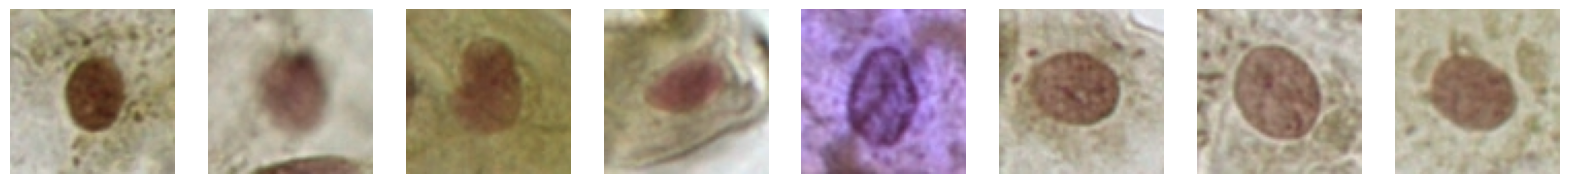

In [7]:
# Investigate the data
import random as rand
print(f"Nr of images in the training set: {len(train)}")
print(f"Nr of images in the validation set: {len(val)}")
print(f"Nr of images in the test set: {len(test)}")

# Display some random images from the training set
n_images = 8
img_indexes = rand.sample(range(0,len(train_dataset)), n_images)

fig, ax = plt.subplots(1,n_images, figsize=(20, 20))
fig.show()
for i, idx in enumerate(img_indexes):
    sample = train_dataset[idx]
    img = sample[0]
    ax[i].imshow(img.permute(1,2,0))
    ax[i].axis('off')
fig.canvas.draw()

In [8]:
print(f"Each sample is of type: {type(sample)}")
img = sample[0]
print(f"Each image is of type: {type(img)} and has dimensions {img.shape}")

Each sample is of type: <class 'tuple'>
Each image is of type: <class 'torch.Tensor'> and has dimensions torch.Size([3, 80, 80])


## Solution

### ML approach

- We split training set 70% - 30% for training and validation.
- We use a CNN model to train on the training set and evaluate on the evaluations set.

In [101]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3),
                      stride=(1, 1), padding=(1, 1)),
            nn.ReLU()
        )

        self.fc = nn.Linear(in_features=12800*2, out_features=2)

    def forward(self, x):
        x = self.conv_network(x)
        x = x.view(-1, 12800*2)
        x = self.fc(x)
        return x

model = ConvNeuralNetwork().to(device)

In [102]:
# Code for ResNet block
# TODO: Perhaps remove this one...
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x
            
class ResNet(nn.Module): #  [3, 4, 6, 3]
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
        
    def _make_layer(self, block, num_residual_block, out_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4 # 256
        
        for i in range(num_residual_block - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64*4 (256) again
            
        return nn.Sequential(*layers)

def ResNet50(img_channels=3, num_classes=2):
    return ResNet(block, [3,4,6,3], img_channels, num_classes)

model = ResNet50().to(device)

### Define the training algorithm

In [103]:
cost_train = []
accuracy_val = []
accuracy_train = []

def train(num_epochs = 1, learning_rate = 0.0001):

    # define loss and optimizer
    optimizer = optim.Adam(model.parameters(),lr = learning_rate)
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(tqdm.tqdm(train_dataloader)):
            
            data = data.to(device)
            targets = targets.to(device)
            
            # forward
            scores = model(data)
            J = loss(scores, targets)
            
            # backward
            optimizer.zero_grad()
            J.backward()
            
            # optimizer step
            optimizer.step()
            
            cost_train.append(J.item())
            
            
        acc_val = check_accuracy(validation_dataloader, model)
        accuracy_val.append(acc_val)
        
        acc_train = check_accuracy(train_dataloader, model)
        accuracy_train.append(acc_train)
        
        print(f'Epoch {epoch+1} validation accuracy {float(acc_val)*100:.2f}%')



def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, pred = scores.max(1)
            
            num_correct += ((pred == y).sum()).item()
            num_samples += pred.size(0)
            
        model.train()
        accuracy = num_correct/num_samples
    return accuracy

### Train the model

In [104]:
import datetime as dt

# Set hyperparameters
learning_rate = 0.0001
momentum = 0.9

cost_train = []
accuracy_val = []
accuracy_train = []

start = dt.datetime.now()

train(NUM_EPOCHS, learning_rate)

print(f"Training duration ", str(dt.datetime.now() - start))


100%|██████████| 802/802 [06:01<00:00,  2.22it/s]


Epoch 1 validation accuracy 85.28%


100%|██████████| 802/802 [06:17<00:00,  2.12it/s]


Epoch 2 validation accuracy 94.23%


100%|██████████| 802/802 [06:11<00:00,  2.16it/s]


Epoch 3 validation accuracy 91.98%


100%|██████████| 802/802 [05:56<00:00,  2.25it/s]


Epoch 4 validation accuracy 90.63%


100%|██████████| 802/802 [05:59<00:00,  2.23it/s]


Epoch 5 validation accuracy 92.39%
Training duration  0:43:23.382977


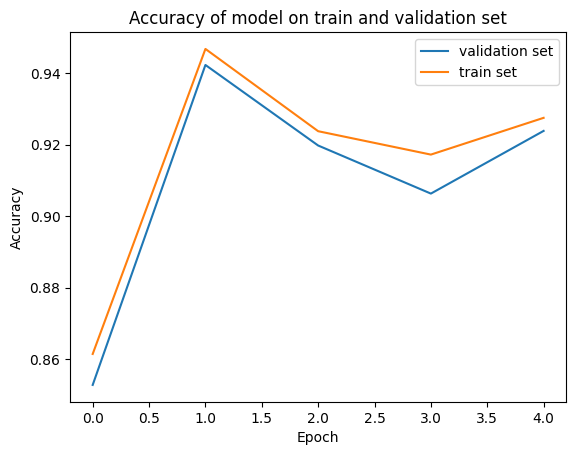

In [105]:
plt.plot(accuracy_val, label='validation set')
plt.plot(accuracy_train, label='train set')
plt.title('Accuracy of model on train and validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ploz')
plt.show()

In [87]:
# Save the entire PyTorch model to a file
name = "cnn"
model_path = f"models/trained_model_{name}.pth"
torch.save(model, model_path)

In [89]:
# Verify loading the saved trained model
trained_model = torch.load(model_path)
print(trained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

## Inference on the test set

In [15]:
# Inference on the test dataset
d = {'Name':[], 'Diagnosis':[]}

for data, name in tqdm.tqdm(test_dataloader):
    model.eval()
    data = data.to(device)
    softmax = nn.Softmax(dim=1)
    
    with torch.no_grad():
        scores = model(data)
        canc_pred = softmax(scores)
        label = canc_pred[:,1].item()

    
    d['Name'].append(name[0])
    d['Diagnosis'].append(label)
    
    model.train()

100%|██████████| 55514/55514 [13:09<00:00, 70.30it/s]


In [16]:
# Save the inference to a file
df = pd.DataFrame(d)
df.to_csv('output/test_predictions.csv', index = False)